In [1]:
from tensorflow.keras.datasets import mnist
import torchvision
from torchvision import transforms
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from time import time

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0


X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [38]:
def view_classify(img, ps, img_title=None):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    if img_title is not None:
        ax1.set_title(img_title)
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Epoch 0 - Training loss: 0.34483797378790404
Epoch 1 - Training loss: 0.14247437088744347
Epoch 2 - Training loss: 0.09851480932580604
Epoch 3 - Training loss: 0.07381086570095581
Epoch 4 - Training loss: 0.05840599526271923
Epoch 5 - Training loss: 0.04609102175843074
Epoch 6 - Training loss: 0.038711842264670296
Epoch 7 - Training loss: 0.03197869180323385
Epoch 8 - Training loss: 0.026660734999718626
Epoch 9 - Training loss: 0.02206016319537305
Epoch 10 - Training loss: 0.01927768421744226
Epoch 11 - Training loss: 0.014996573646011244
Epoch 12 - Training loss: 0.01506030531432724
Epoch 13 - Training loss: 0.012966507564761027
Epoch 14 - Training loss: 0.011461852653962518

Training Time (in minutes) = 0.36216665903727213
Predicted Digit = 2
Number Of Images Tested = 10000

Model Accuracy = 0.9791


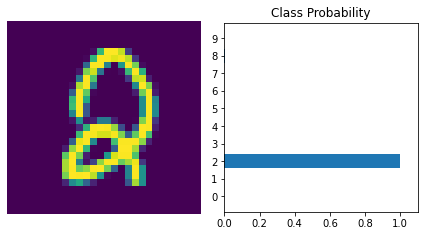

In [5]:
# Now let's start training the network

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

def train_model(model, x_train, x_test, y_train, y_test, epochs=15):
    transform = transforms.Compose([transforms.Normalize((0,), (1,)),])
    
    #trainset = datasets.MNIST('../', download=True, train=True, transform=transform)
    #valset = datasets.MNIST('../', download=True, train=False, transform=transform)
    trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).type(torch.long))
    valset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test).type(torch.long))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

    criterion = nn.NLLLoss()
    images, labels = next(iter(trainloader))
    images = images.view(images.shape[0], -1)
    labels = labels

    logps = model(images)
    loss = criterion(logps, labels)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    time0 = time()
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:

            images = images.view(images.shape[0], -1)
            labels = labels

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)


    images, labels = next(iter(valloader))

    img = images[0].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    print("Predicted Digit =", probab.index(max(probab)))
    view_classify(img.view(1, 28, 28), ps)

    correct_count, all_count = 0, 0
    for images,labels in valloader:
        for i in range(len(labels)):
            img = images[i].view(1, 784)
            with torch.no_grad():
                logps = model(img)


            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count/all_count))
    
    return model
    
model = train_model(model, X_train, X_test, y_train, y_test, epochs=15)

In [6]:
def get_network_outputs(model, dataloader):
    """ Returns the network outputs and original labels of samples in the given dataloader.
    """
    network_outputs = list()
    with torch.no_grad():
        for x, _ in dataloader:
            network_outputs.append(model(x))
            
    network_outputs = np.concatenate(network_outputs)
    
    return network_outputs

def add_adversarial_noise(model, dataloader, eps=3e-2):
    """ Returns an ndarray of adversarially perturbed versions of the data passed in with the dataloader, 
        generated by a white-box FGSM attack on the provided network.
    """
    adv_images = list()
    for x, y in dataloader:
        adv_images.append(fast_gradient_method(model, x, eps, np.inf).detach().numpy())
            
    adv_images = np.concatenate(adv_images)
    
    return adv_images
    

def one_vs_all_dataloader(data, labels, digit):
    """ Returns dataloader with labels modified so that samples belonging to the specified class have a 
        label of 1, and all other samples have a label of 0
    """
    one_v_all_labels = np.zeros(labels.shape, dtype=labels.dtype)
    
    current_digit_idx = np.where(labels == digit)
    one_v_all_labels[current_digit_idx] = 1
    
    dataset = torch.utils.data.TensorDataset(torch.Tensor(data), torch.Tensor(labels).type(torch.long))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    
    return dataloader, one_v_all_labels

In [7]:
def model_confidence_intervals(clean_outputs, adv_outputs, labels, curr_digit):
    """ Returns the indices of outputs for which the clean image is correctly classified and
        the adversarial version is not. Return type is a dict, where the keys indicate intervals
        of confidence with which the model incorrectly classified the adversarial data.
    """
    confidence_range_pair_indices = dict()
    
    for idx in range(clean_outputs.shape[0]):
        sample_is_curr_digit = labels[idx] == 1
        if not sample_is_curr_digit:
            continue
        
        logps = clean_outputs[idx]
        adv_logps = adv_outputs[idx]
        
        ps = np.exp(logps)
        probab = list(ps)
        pred_label = probab.index(max(probab))

        # If original image is correctly classified
        if (pred_label == curr_digit):
            adv_ps = np.exp(adv_logps)
            adv_probab = list(adv_ps)
            adv_pred_label = adv_probab.index(max(adv_probab))
            
            # If adversarial version of image is misclassified
            if (curr_digit != adv_pred_label):
                # Identify confidence range and save the model output for that image
                confidence = adv_ps.max().item()
                if ((confidence > .5 and confidence <= .6) and not ".5-.6" in confidence_range_pair_indices):
                    confidence_range_pair_indices[".5-.6"] = idx
                    
                elif ((confidence > .6 and confidence <= .7) and not ".6-.7" in confidence_range_pair_indices):
                    confidence_range_pair_indices[".6-.7"] = idx
                    
                elif ((confidence > .7 and confidence <= .8) and not ".7-.8" in confidence_range_pair_indices):
                    confidence_range_pair_indices[".7-.8"] = idx
                    
                elif ((confidence > .8 and confidence <= .9) and not ".8-.9" in confidence_range_pair_indices):
                    confidence_range_pair_indices[".8-.9"] = idx
                    
                elif ((confidence > .9 and confidence <= 1) and not ".9-1" in confidence_range_pair_indices):
                    confidence_range_pair_indices[".9-1"] = idx

    return confidence_range_pair_indices

In [8]:
def high_confidence_misclassified_sample_index(clean_outputs, adv_outputs, labels, curr_digit):
    """ Returns the index of an output for which the clean image is correctly classified and the
        adversarial image is misclassified with high (>90%) confidence.
    """
    for idx in range(clean_outputs.shape[0]):
        sample_is_curr_digit = labels[idx] == 1
        if not sample_is_curr_digit:
            continue
        
        logps = clean_outputs[idx]
        adv_logps = adv_outputs[idx]

        ps = np.exp(logps)
        probab = list(ps)
        pred_label = probab.index(max(probab))

        # If original image is correctly classified
        if (pred_label == curr_digit):
            adv_ps = np.exp(adv_logps)
            adv_probab = list(adv_ps)
            adv_pred_label = adv_probab.index(max(adv_probab))

            # If adversarial version of image is misclassified with high confidence
            confidence = adv_ps.max().item()
            if ((curr_digit != adv_pred_label) and (confidence > .9 and confidence <= 1)):
                return idx

### Comparing distance from cluster for advsersarial samples misclassified with different levels of confidence

In [9]:
curr_digit = 0
eps = 3e-2

loader, labels = one_vs_all_dataloader(X_test, y_test, curr_digit)

# Generate adversarial samples
adv_data = add_adversarial_noise(model, loader, eps=eps)
adv_loader, _ = one_vs_all_dataloader(adv_data, y_test, curr_digit)

# Get model outputs for clean and adversarial data
clean_outputs = get_network_outputs(model, loader)
adv_outputs = get_network_outputs(model, adv_loader)

interval_indices = model_confidence_intervals(clean_outputs, adv_outputs, labels, curr_digit)

In [10]:
intervals = [".5-.6", ".6-.7", ".7-.8", ".8-.9", ".9-1"]

num_sample_outputs = clean_outputs.shape[0]
adv_intervals = np.zeros((len(intervals), 10), dtype=float)
for i, conf_interval in enumerate(intervals):
    # Put each of the adversarial samples found into an array to append to the clean output data
    adv_intervals[i] = adv_outputs[interval_indices[conf_interval]]
    # Replace single index in interval indices with a tuple of indices: first being the index of
    # the clean sample in intervals_data (defined below) and second being the index of that 
    # sample's adversarial counterpart
    interval_indices[conf_interval] = (interval_indices[conf_interval], num_sample_outputs + i)

# Data to visualize with TSNE: clean outputs with adversarial outputs in different confidence ranges
intervals_data = np.append(clean_outputs, adv_intervals, axis=0)
print(intervals_data.shape)

(10005, 10)


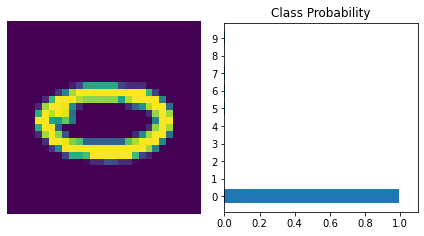

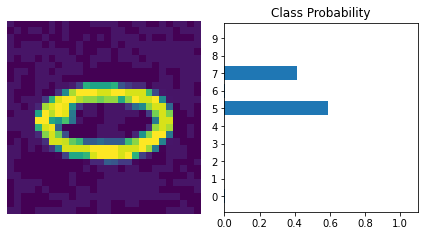

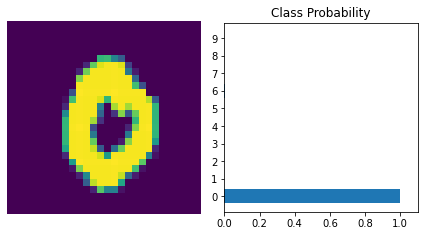

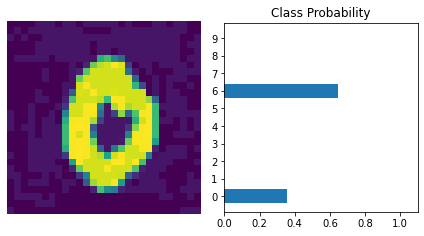

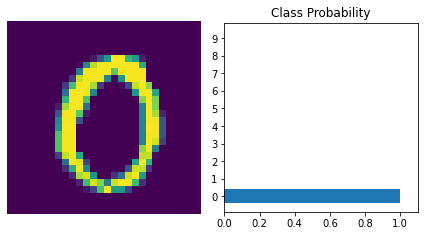

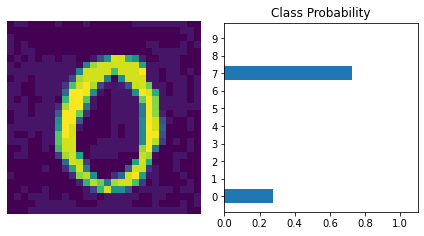

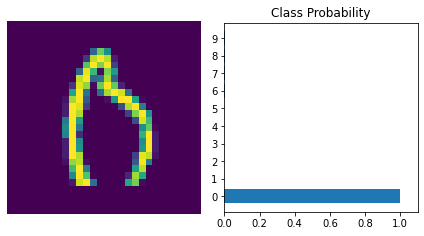

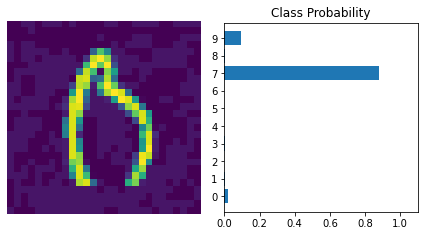

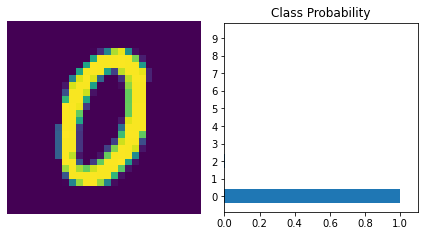

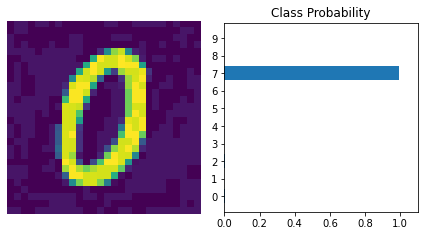

In [11]:
for i, conf_interval in enumerate(intervals):
    view_classify(torch.from_numpy(X_test[interval_indices[conf_interval][0]]), torch.from_numpy(np.exp(intervals_data[interval_indices[conf_interval][0]])))
    view_classify(torch.from_numpy(adv_data[interval_indices[conf_interval][0]]), torch.from_numpy(np.exp(intervals_data[interval_indices[conf_interval][1]])))

In [12]:
tsne_intervals = TSNE(n_components=2, perplexity = 50, n_iter = 2000).fit_transform(intervals_data)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


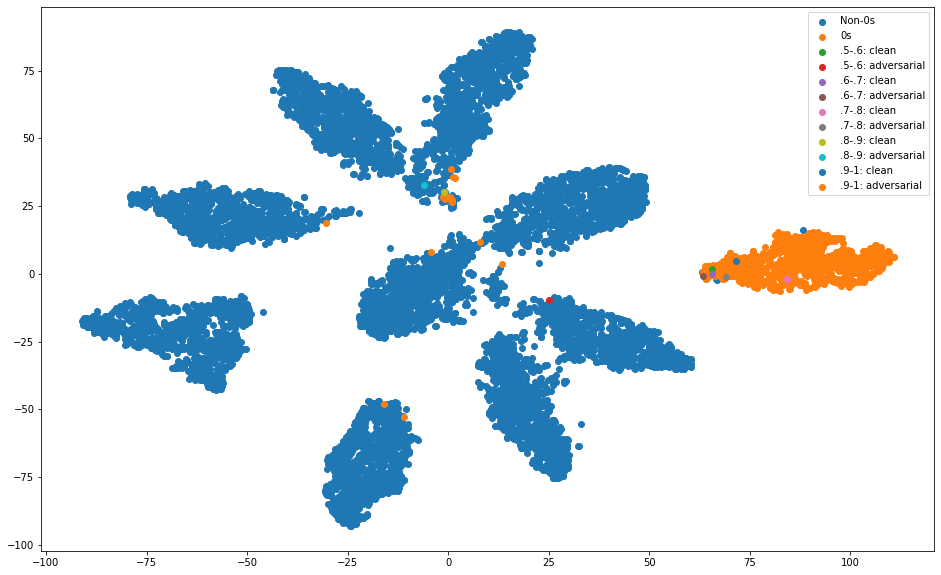

In [13]:
other_digits_idx = np.where(labels == 0)
current_digit_idx = np.where(labels == 1)

plt.figure(figsize=(16,10))
plt.scatter(tsne_intervals[other_digits_idx,0], tsne_intervals[other_digits_idx,1], label="Non-" + str(curr_digit) + "s")
plt.scatter(tsne_intervals[current_digit_idx,0], tsne_intervals[current_digit_idx,1], label=str(curr_digit) + "s")
for conf_interval in intervals:
    clean_idx = interval_indices[conf_interval][0]
    adv_idx = interval_indices[conf_interval][1]
    plt.scatter(tsne_intervals[clean_idx,0], tsne_intervals[clean_idx,1], label=conf_interval + ": clean")
    plt.scatter(tsne_intervals[adv_idx,0], tsne_intervals[adv_idx,1], label=conf_interval + ": adversarial")
plt.legend()

### Comparing distance between clean sample and that sample with added adversarial noise in input and output space

In [14]:
curr_digit = 0
eps = 3e-2

loader, labels = one_vs_all_dataloader(X_test, y_test, curr_digit)

# Generate adversarial samples
adv_data = add_adversarial_noise(model, loader, eps=eps)
adv_loader, _ = one_vs_all_dataloader(adv_data, y_test, curr_digit)

# Get model outputs for clean and adversarial data
clean_outputs = get_network_outputs(model, loader)
adv_outputs = get_network_outputs(model, adv_loader)

# Get index of a sample that is misclassified with high confidence by the model
index_of_sample = high_confidence_misclassified_sample_index(clean_outputs, adv_outputs, labels, curr_digit)
print(index_of_sample)

215


In [15]:
clean_outputs.shape

(10000, 10)

In [16]:
print(index_of_sample)
adv_data[index_of_sample].shape

215


(784,)

In [17]:
# Concatenate clean and adversarial samples into a single ndarray each (for passing to TSNE transform)
input_data = np.append(X_test, np.expand_dims(adv_data[index_of_sample], axis=0), axis=0)
output_data = np.append(clean_outputs, np.expand_dims(adv_outputs[index_of_sample], axis=0), axis=0)

index_of_adv_sample = len(X_test)

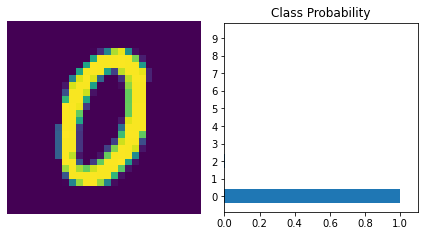

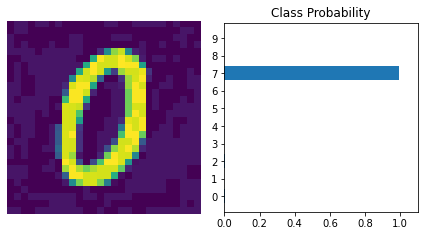

In [18]:
view_classify(torch.from_numpy(input_data[index_of_sample]), torch.from_numpy(np.exp(output_data[index_of_sample])))
view_classify(torch.from_numpy(input_data[index_of_adv_sample]), torch.from_numpy(np.exp(output_data[index_of_adv_sample])))

In [19]:
pca = PCA(n_components = 50, random_state = 42)

In [20]:
tsne_input = TSNE(n_components=2, perplexity = 50, n_iter = 2000).fit_transform(pca.fit_transform(input_data))

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


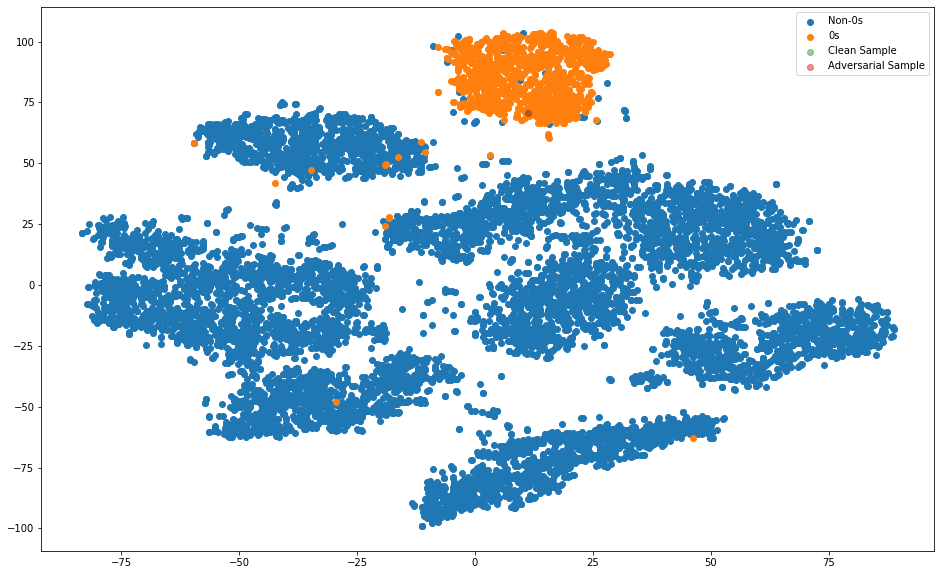

In [21]:
other_digits_idx = np.where(labels == 0)
current_digit_idx = np.where(labels == 1)

plt.figure(figsize=(16,10))
plt.scatter(tsne_input[other_digits_idx,0], tsne_input[other_digits_idx,1], label="Non-" + str(curr_digit) + "s")
plt.scatter(tsne_input[current_digit_idx,0], tsne_input[current_digit_idx,1], label=str(curr_digit) + "s")
plt.scatter(tsne_input[index_of_sample,0], tsne_input[index_of_sample,1], label="Clean Sample", alpha=0.5)
plt.scatter(tsne_input[index_of_adv_sample,0], tsne_input[index_of_adv_sample,1], label="Adversarial Sample", alpha=0.5)
plt.legend()

In [22]:
tsne_output = TSNE(n_components=2, perplexity = 50, n_iter = 2000).fit_transform(output_data)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


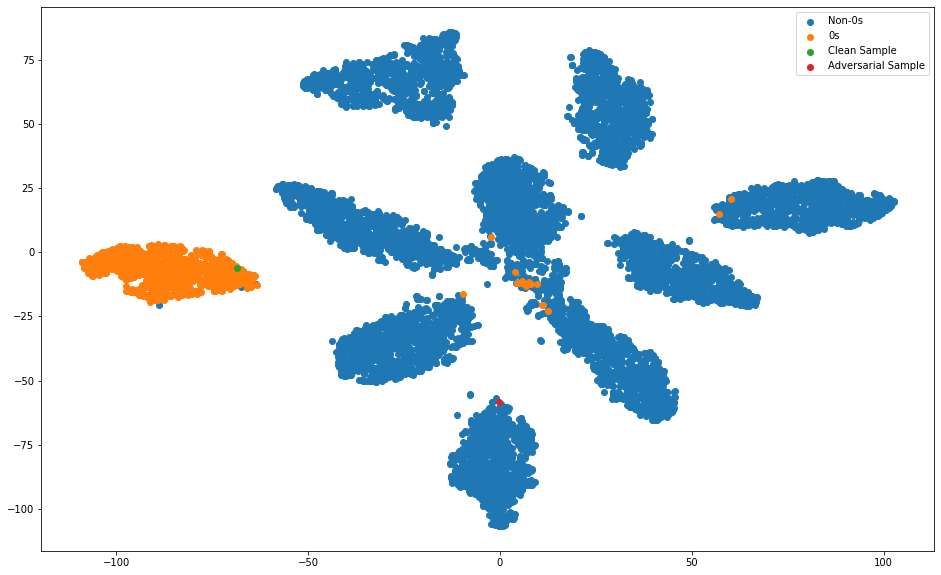

In [23]:
other_digits_idx = np.where(labels == 0)
current_digit_idx = np.where(labels == 1)

plt.figure(figsize=(16,10))
plt.scatter(tsne_output[other_digits_idx,0], tsne_output[other_digits_idx,1], label="Non-" + str(curr_digit) + "s")
plt.scatter(tsne_output[current_digit_idx,0], tsne_output[current_digit_idx,1], label=str(curr_digit) + "s")
plt.scatter(tsne_output[index_of_sample,0], tsne_output[index_of_sample,1], label="Clean Sample")
plt.scatter(tsne_output[index_of_adv_sample,0], tsne_output[index_of_adv_sample,1], label="Adversarial Sample")
plt.legend()

### Tracking Image Distance From Cluster as Epsilon Increases

<ipython-input-38-9c7ebfa2273a>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)


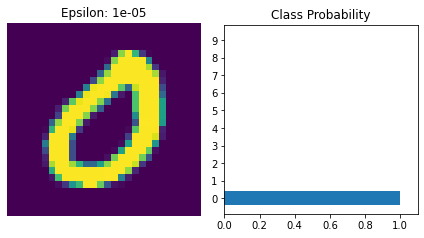

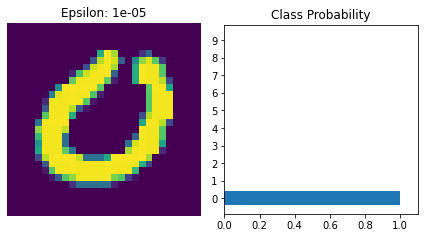

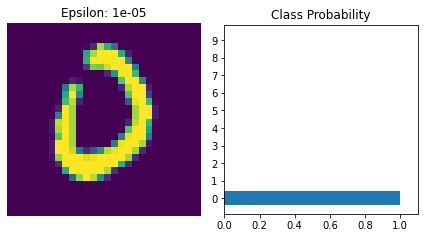

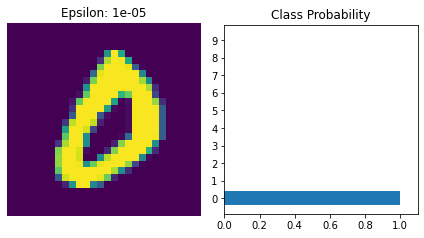

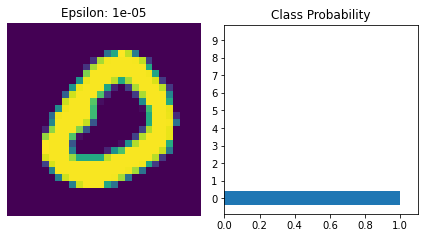

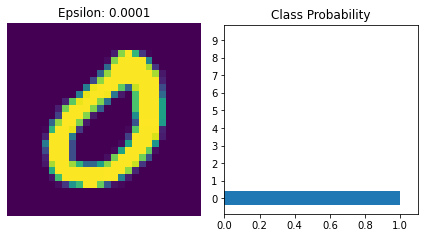

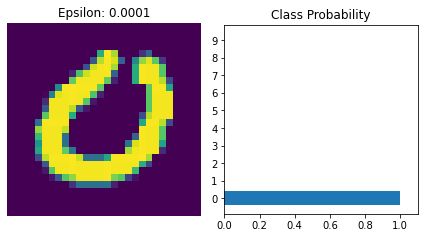

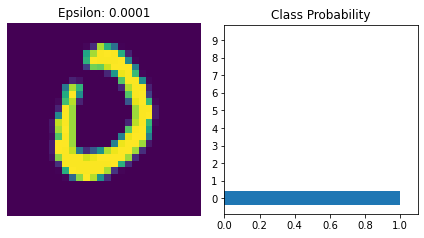

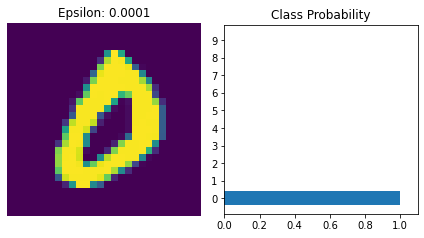

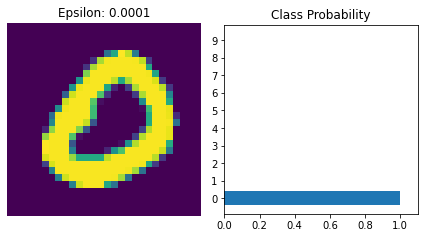

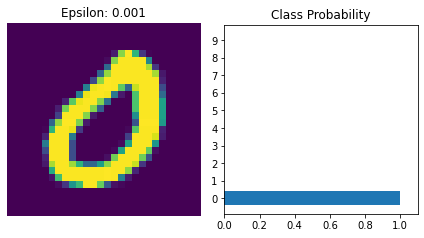

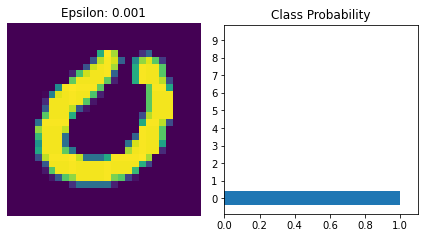

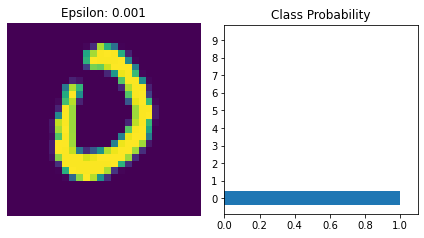

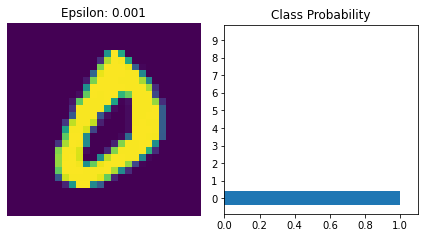

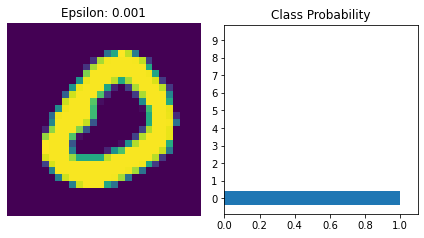

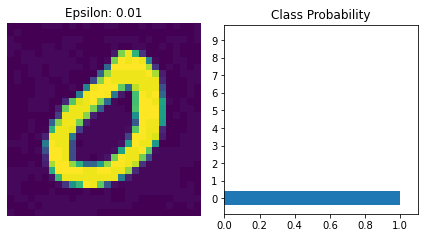

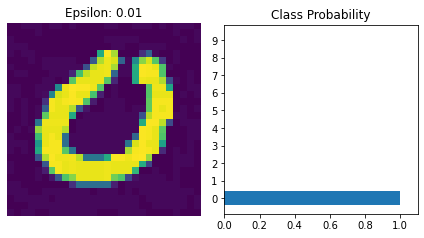

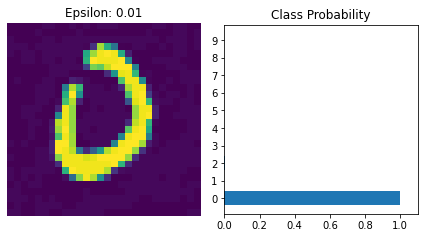

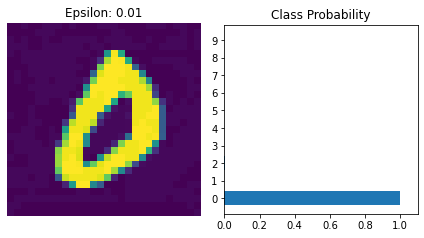

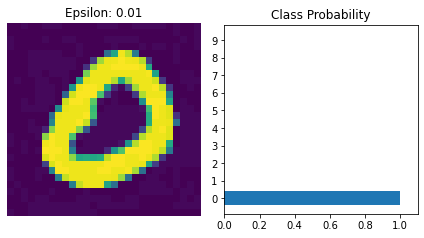

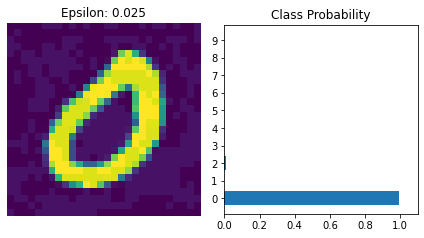

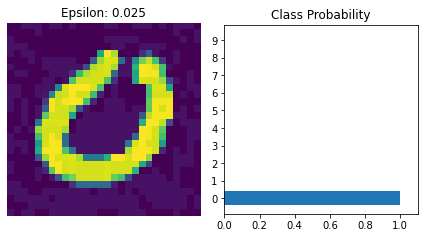

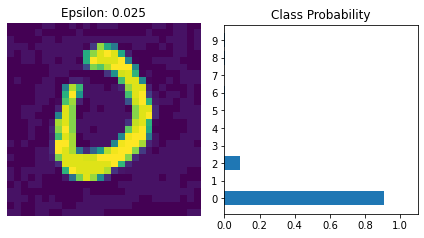

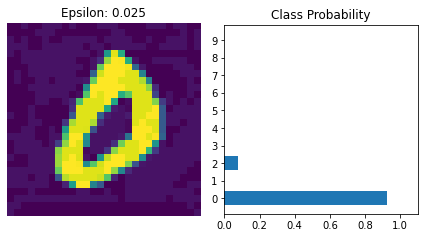

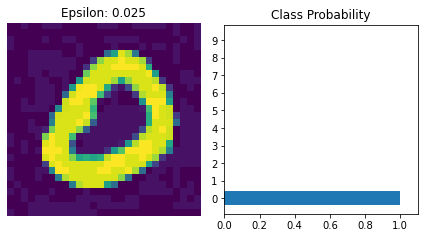

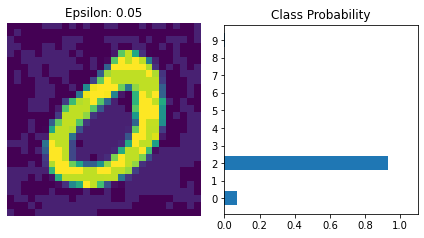

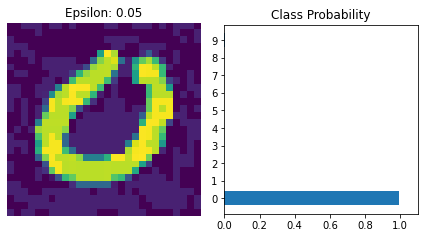

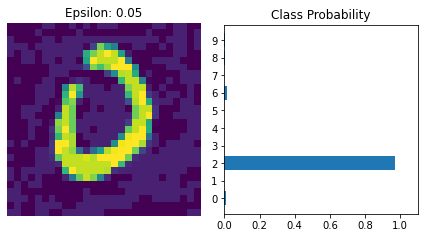

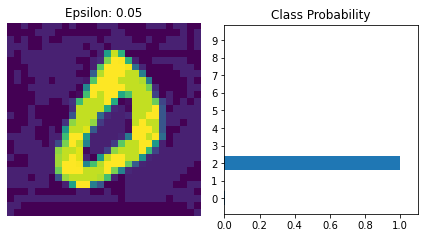

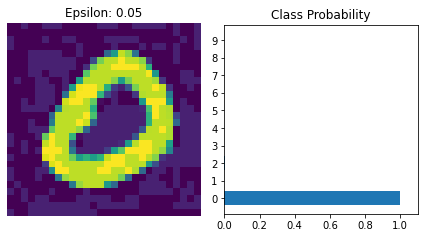

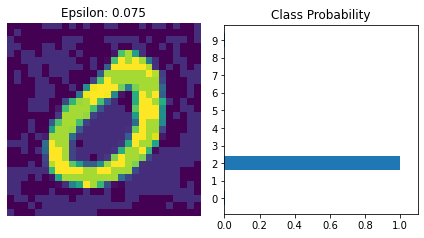

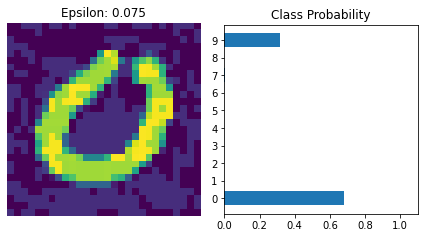

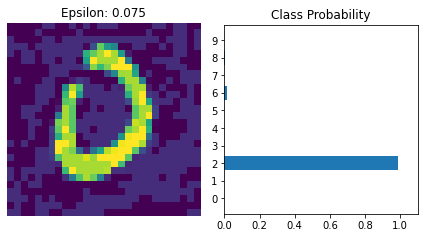

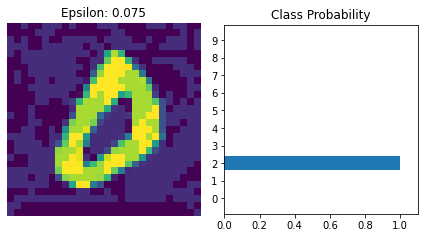

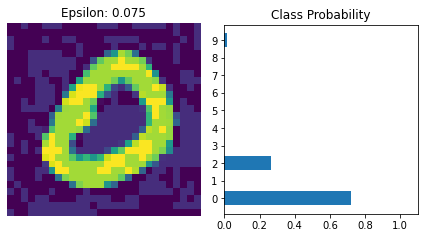

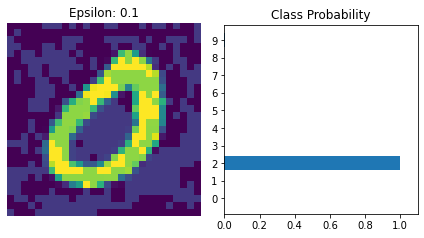

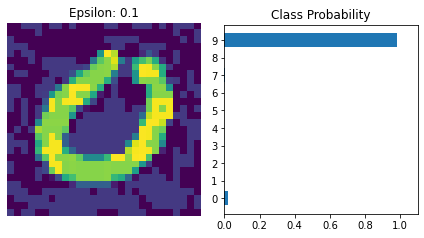

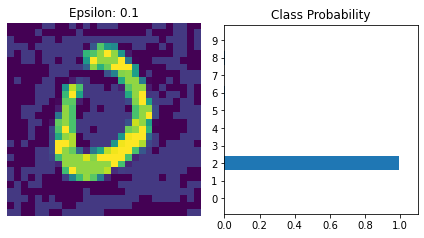

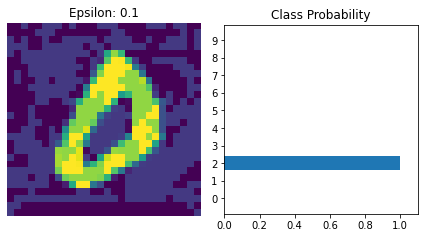

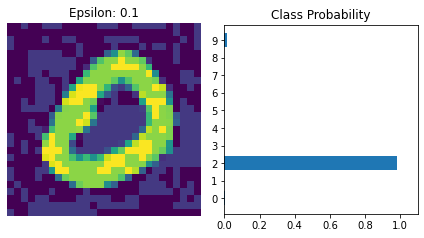

In [56]:
curr_digit = 0
epsilons = [1e-5, 1e-4, 1e-3, 1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1]
num_samples = 5

loader, labels = one_vs_all_dataloader(X_test, y_test, curr_digit)
model_outputs = get_network_outputs(model, loader)

# Get num_samples random indices where the model correctly classifies samples of curr_digit
model_preds = np.argmax(model_outputs, axis=1)
correct = np.where(model_preds == y_test)[0] # Indices of samples that are correctly classified by the model
current_digit_idx = np.where(labels == 1)[0] # Indices of samples belonging to curr_digit class
# Intersection of above two arrays
correctly_classified_curr_digit_samples = np.intersect1d(correct, current_digit_idx, assume_unique=True)

# [num_samples] random samples selected from the correctly classified samples belonging to curr_digit
rand_indices = np.random.randint(0, len(correctly_classified_curr_digit_samples), size=num_samples)
rand_curr_digit_samples = correctly_classified_curr_digit_samples[rand_indices]

# 2d dict to store index of sample by index of original image and magnitude of adversarial noise (epsilon)
adv_sample_indices = dict()
for sample_idx in rand_curr_digit_samples:
    adv_sample_indices[str(sample_idx)] = dict()

max_idx = X_test.shape[0] # Keeps track of number of samples in output array, to save indices of added adv samples
for eps in epsilons:
    rand_adv_samples = np.zeros((num_samples, model_outputs.shape[1]), dtype=float)
    for i, sample_idx in enumerate(rand_curr_digit_samples):
        # Add adversarial noise of eps magnitude to sample
        x = torch.from_numpy(X_test[sample_idx]).unsqueeze(axis=0)
        x_fgm = fast_gradient_method(model, x, eps, np.inf)
        with torch.no_grad():
            adv_output = model(x_fgm).detach().numpy()
            x_fgm = x_fgm.detach().numpy()
            
        view_classify(torch.from_numpy(x_fgm), torch.from_numpy(np.exp(adv_output)), img_title='Epsilon: ' + str(eps))
        
        # Add sample's output to outputs array and keep a reference of its index
        rand_adv_samples[i] = adv_output
        adv_sample_indices[str(sample_idx)][str(eps)] = max_idx
        max_idx += 1
    model_outputs = np.append(model_outputs, rand_adv_samples, axis=0)

In [57]:
model_outputs.shape

(10040, 10)

In [58]:
tsne_output = TSNE(n_components=2, perplexity = 50, n_iter = 2000).fit_transform(model_outputs)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [59]:
clf = SVC(kernel='rbf', C=1e-2, random_state=42, max_iter = 1e5).fit(tsne_output[:10000], labels[:10000])

decision_function = clf.decision_function(tsne_output)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = tsne_output[support_vector_indices]

other_digits_idx = np.where(labels == 0)
current_digit_idx = np.where(labels == 1)

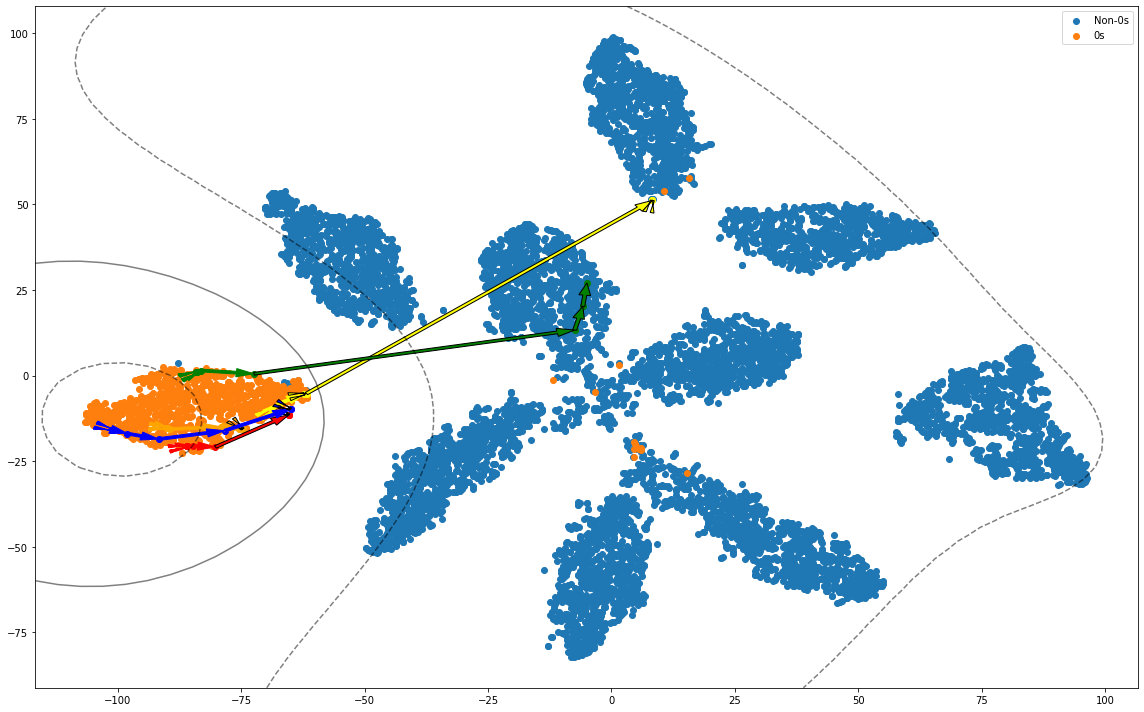

In [60]:
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'purple', 'black', 'gray', 'lightcoral', 'tan', 'khaki', 'lime', 'aqua', ]
plt.figure(figsize=(16,10))
plt.scatter(tsne_output[other_digits_idx,0], tsne_output[other_digits_idx,1], label="Non-" + str(curr_digit) + "s")
plt.scatter(tsne_output[current_digit_idx,0], tsne_output[current_digit_idx,1], label=str(curr_digit) + "s")
for idx in rand_curr_digit_samples:
    x = tsne_output[idx, 0]
    y = tsne_output[idx, 1]
    plt.scatter(x, y, c=colors[0])
    for i, eps in enumerate(epsilons):
        dx = tsne_output[adv_sample_indices[str(idx)][str(eps)], 0] - x
        dy = tsne_output[adv_sample_indices[str(idx)][str(eps)], 1] - y
        correct = np.argmax(model_outputs[adv_sample_indices[str(idx)][str(eps)]]) == curr_digit
        if correct:
            plt.arrow(x, y, dx, dy, width=0.8, length_includes_head=True, color=colors[0])
        else:
            plt.arrow(x, y, dx, dy, width=0.8, length_includes_head=True, facecolor=colors[0])
        x = tsne_output[adv_sample_indices[str(idx)][str(eps)], 0]
        y = tsne_output[adv_sample_indices[str(idx)][str(eps)], 1]
        plt.scatter(x, y, c=colors[0])
    colors.remove(colors[0])

# Plotting RBF SVM
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(
    xx,
    yy,
    Z,
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
)
    
plt.tight_layout()
plt.legend()